In [54]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend

import time
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

In [33]:
def load_image(image_path):
    image=Image.open(image_path)
    image=image.resize((512,512))
    return image

def add_dim(image):
    img_array=np.asarray(image,dtype='float32')
    img_array=np.expand_dims(img_array,axis=0)
    return img_array

def reversing_rgb(img_array):
    img_array[:, :, :,0]-=103.939
    img_array[:, :, :,1]-=116.779
    img_array[:, :, :,2]-=123.68
    
    img_array=img_array[:, :, :,::-1]
    return img_array


In [50]:
content_image=load_image('effiell.jpg!d')
content_array=add_dim(content_image)
content_imagee=reversing_rgb(content_array)
style_image=load_image('van.JFIF')
style_array=add_dim(style_image)
style_imagee=reversing_rgb(style_array)
print(content_array.shape)
print(style_array.shape)


(1, 512, 512, 3)
(1, 512, 512, 3)


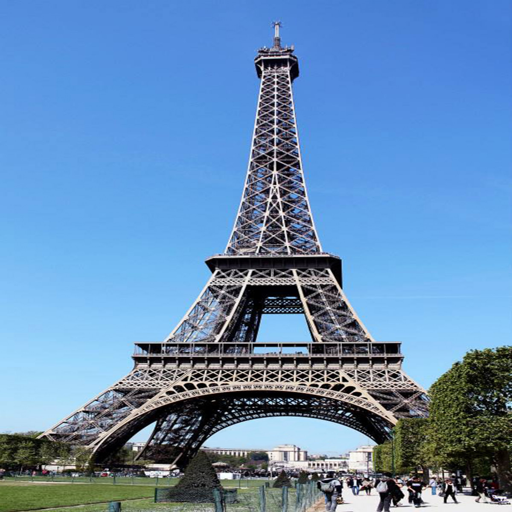

In [41]:
load_image('effiell.jpg!d')

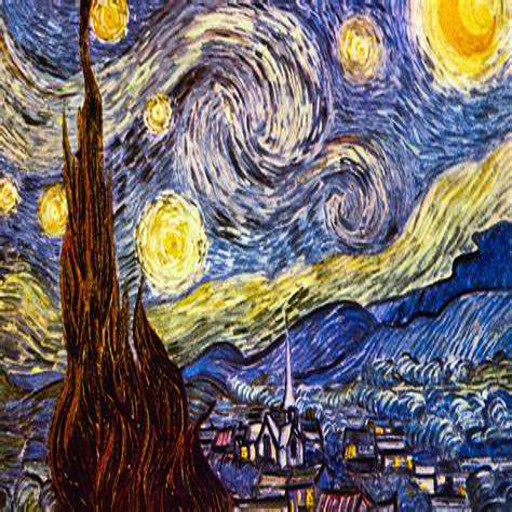

In [40]:
load_image('van.JFIF')

In [51]:
style_image=backend.variable(style_imagee)
content_image=backend.variable(content_imagee)
final_image=backend.placeholder((1,512,512,3))

In [56]:
input_tensor=backend.concatenate([content_image,style_image,final_image], axis=0)


  <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


In [57]:
model= VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 43s 1us/step


In [58]:
layers=dict([(layer.name,layer.output) for layer in model.layers])
layers

{'input_1': <KerasTensor: shape=(1, 512, 512, 3) dtype=float32 (created by layer 'input_1')>,
 'tf.concat': <KerasTensor: shape=(3, 512, 512, 3) dtype=float32 (created by layer 'tf.concat')>,
 'block1_conv1': <KerasTensor: shape=(3, 512, 512, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(3, 512, 512, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(3, 256, 256, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(3, 256, 256, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(3, 256, 256, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(3, 128, 128, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(3, 128, 128, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(3, 128, 128, 256) dtype=float32 (cr

In [59]:
alpha= 0.025
beta=4.0
gamma=1.25

In [61]:
loss=backend.variable(0.)

In [65]:
def content_loss(content,combination):
    return backend.sum(backend.square(combination-content))

In [70]:
layer_features=layers['block2_conv2']
content_features=layer_features[0,:,:,:]
final_features=layer_features[2,:,:,:]

loss=loss + alpha * content_loss(content_features,final_features)



In [71]:
def gram_matrix(T):
    features=backend.batch_flatten(backend.permute_dimensions(T, (2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

In [77]:
def style_loss(style,final):
    sty=  gram_matrix(style)
    fin= gram_matrix(final)
    return backend.sum(backend.square(sty-fin))/ (4 * (3**2) * (262144**2))

feature_layers=['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    final_features=layer_features[2,:,:,:]
    loss = loss + (beta/len(feature_layers))*(style_loss(style_features,final_features))

In [80]:
def total_var_loss(T):
    a= backend.square(T[:,511,511]-T[:,1:,511,:])
    b= backend.square(T[:,511,511]-T[:,511:,1:,:])
    return backend.sum(backend.pow(a+b,1.25))

loss= loss + gamma*total_var_loss(final_image)